In [609]:
import pandas as pd

In [610]:
import pickle
import sys
import os

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join("../..")))  # if you're in optimizer/

with open("../parameters/simulation_parameters.pkl", "rb") as f:
    sim_params = pickle.load(f)

simulated_logs = pd.read_csv("../../simulated_log.csv")
logs = pd.read_csv("../../raw_data/LoanApp.csv.gz", compression='gzip')

Agent timelines

In [611]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.cm as cm

def plot_agent_timeline_by_case(df, agent_id):
    df = df.copy()
    df['start'] = pd.to_datetime(df['start'], format='mixed', utc=True)
    df['end'] = pd.to_datetime(df['end'], format='mixed', utc=True)
    df = df[df['agent'] == agent_id].sort_values('start')

    case_ids = df['case_id'].unique()
    activity_types = df['activity'].unique()

    cmap = cm.get_cmap('tab20', len(activity_types))
    activity_to_color = {act: cmap(i) for i, act in enumerate(activity_types)}
    case_to_y = {case: i for i, case in enumerate(case_ids)}

    fig, ax = plt.subplots(figsize=(14, len(case_ids) * 0.4 + 2))

    for _, row in df.iterrows():
        y = case_to_y[row['case_id']]
        color = activity_to_color[row['activity']]
        ax.hlines(y, xmin=row['start'], xmax=row['end'],
                  linewidth=6, color=color, alpha=0.9)

    ax.set_yticks(list(case_to_y.values()))
    ax.set_yticklabels([f"Case {cid}" for cid in case_ids])
    ax.set_xlabel("Time")
    ax.set_title(f"Agent {agent_id} Activity Timeline by Case")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in activity_to_color.values()]
    labels = list(activity_to_color.keys())
    ax.legend(handles, labels, title="Activity", bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


/var/folders/x3/5rg2fq097snf05l9glzskh9r0000gn/T/ipykernel_87504/731271094.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



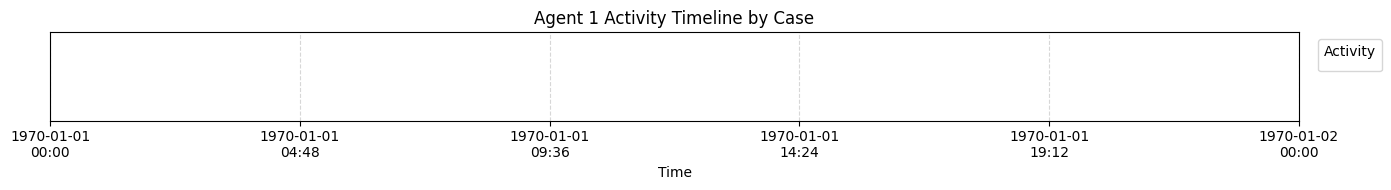

In [612]:
plot_agent_timeline_by_case(simulated_logs, agent_id=1)


Validation checks

In [613]:
from collections import defaultdict
import pandas as pd
import math
import scipy.stats as st
from datetime import datetime, timedelta

In [614]:
def sample_from_distribution(distribution):
    """
    Copy of the AgentSimulator utils method
    """
    if distribution.type.value == "expon":
        scale = distribution.mean - distribution.min
        if scale < 0.0:
            print("Warning! Trying to generate EXPON sample with 'mean' < 'min', using 'mean' as scale value.")
            scale = distribution.mean
        sample = st.expon.rvs(loc=distribution.min, scale=scale, size=1)
    elif distribution.type.value == "gamma":
        # If the distribution corresponds to a 'gamma' with loc!=0, the estimation is done wrong
        # dunno how to take that into account
        sample = st.gamma.rvs(
            pow(distribution.mean, 2) / distribution.var,
            loc=0,
            scale=distribution.var / distribution.mean,
            size=1,
        )
    elif distribution.type.value == "norm":
        sample = st.norm.rvs(loc=distribution.mean, scale=distribution.std, size=1)
    elif distribution.type.value == "uniform":
        sample = st.uniform.rvs(loc=distribution.min, scale=distribution.max - distribution.min, size=1)
    elif distribution.type.value == "lognorm":
        # If the distribution corresponds to a 'lognorm' with loc!=0, the estimation is done wrong
        # dunno how to take that into account
        pow_mean = pow(distribution.mean, 2)
        phi = math.sqrt(distribution.var + pow_mean)
        mu = math.log(pow_mean / phi)
        sigma = math.sqrt(math.log(phi ** 2 / pow_mean))
        sample = st.lognorm.rvs(sigma, loc=0, scale=math.exp(mu), size=1)
    elif distribution.type.value == "fix":
        sample = [distribution.mean] * 1

    return sample[0]

def remove_transitive_response_constraints(response_constraints):
    cleaned = {}

    for act, responses in response_constraints.items():
        direct = set(responses)

        # Remove any activity that is indirectly reachable through other responses
        for mid in responses:
            indirects = set(response_constraints.get(mid, []))
            direct -= indirects

        cleaned[act] = list(direct)

    return cleaned


def discover_post_conditions(df, activity_col='activity', case_col='case_id', order_by='end_time'):
    response_counts = defaultdict(lambda: defaultdict(int))
    activity_counts = defaultdict(int)

    # Group by case
    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()

        for i, act in enumerate(sorted_activities):
            activity_counts[act] += 1

            # All activities that come after this one
            for after_act in sorted_activities[i+1:]:
                response_counts[act][after_act] += 1

    # Build final response constraint map
    post_conditions = {}
    for act, after_acts in response_counts.items():
        constraints = []
        for after_act, count in after_acts.items():
            # Threshold: e.g., B happens after A in 80%+ of A occurrences
            if count / activity_counts[act] >= 1:
                constraints.append(after_act)
        if constraints:
            post_conditions[act] = constraints

    post_conditions = remove_transitive_response_constraints(post_conditions)

    return post_conditions


def extract_all_successors(transition_dict):
    """
    Converts a nested transition dictionary to a flat mapping:
    prefix_activity → list of all possible successor activities (non-zero prob)

    Parameters:
    - transition_dict: dict of {prefix: {agent_id: {activity: prob}}} ! Careful, only one activity prefixes are valid

    Returns:
    - dict of {activity: [possible next activities]}
    """
    flat_successors = {}
    seen_anchors = set()

    for prefix, agent_dict in transition_dict.items():
        if not prefix:
            continue  # skip empty prefixes
        if prefix[-1] in seen_anchors:
            continue
        anchor = prefix[-1]  # last activity in the prefix
        seen_anchors.add(anchor)

        successor_set = set()
        for agent_transitions in agent_dict.values():
            for act, prob in agent_transitions.items():
                if prob > 0:
                    successor_set.add(act)

        flat_successors[anchor] = sorted(successor_set)

    return flat_successors


def mine_concurrent_activities(df, case_col='case_id', activity_col='activity',
                                start_col='start_time', end_col='end_time'):
    """
    For each activity, detect other activities that can run concurrently
    by overlapping time windows in the same case.

    Parameters:
    - df: Event log with case_id, activity, start_time, end_time

    Returns:
    - co_occurrence: dict {activity: [other activities that overlapped with it]}
    """
    df = df.copy()
    df[start_col] = pd.to_datetime(df[start_col], format='mixed', utc=True)
    df[end_col] = pd.to_datetime(df[end_col], format='mixed', utc=True)


    co_occurrence = defaultdict(set)

    for case_id, group in df.groupby(case_col):
        group = group.sort_values(by=start_col)
        for i, row_i in group.iterrows():
            act_i, start_i, end_i = row_i[activity_col], row_i[start_col], row_i[end_col]
            for j, row_j in group.iterrows():
                if i == j:
                    continue
                act_j, start_j, end_j = row_j[activity_col], row_j[start_col], row_j[end_col]
                # Check for overlap
                if start_i < end_j and start_j < end_i:
                    co_occurrence[act_i].add(act_j)

    # Convert sets to sorted lists
    return {act: sorted(list(others)) for act, others in co_occurrence.items()}

def extract_xor_groups_from_cooccurrence(successor_map, co_occurrence_map):
    """
    Builds XOR groups from a simplified co-occurrence map.
    An activity is excluded from XOR groups if it can co-occur with the anchor.
    Returns:
    - xor_groups: {anchor: list of mutually exclusive groups (each group is a list of activities)}
    """
    xor_groups = defaultdict(list)

    for anchor, successors in successor_map.items():
        if not successors:
            continue

        # ⚠️ Filter out successors that can co-occur with the anchor
        filtered_successors = [
            act for act in successors
            if act not in co_occurrence_map.get(anchor, []) and anchor not in co_occurrence_map.get(act, [])
        ]

        remaining = set(filtered_successors)
        groups = []

        while remaining:
            act = remaining.pop()
            group = {act}

            for other in list(remaining):
                if (
                    act in co_occurrence_map.get(other, []) or
                    other in co_occurrence_map.get(act, [])
                ):
                    group.add(other)
                    remaining.remove(other)

            groups.append(sorted(group))

        if len(groups) > 1:
            xor_groups[anchor] = groups

    return xor_groups

# Note to self. This does not cover cases like: Reject application cannot happen after Approve application

def discover_prerequisites_from_log(df, activity_col='activity', case_col='case_id', order_by='end_time'):
    # Step 1: Collect all activities that appear before each activity in each case
    activity_to_preceding_sets = defaultdict(list)

    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()
        seen = set()
        for i, act in enumerate(sorted_activities):
            activity_to_preceding_sets[act].append(seen.copy())
            seen.add(act)

    # Step 2: Intersect the "seen-before" sets across all cases
    raw_prerequisites = {}
    for act, preceding_sets in activity_to_preceding_sets.items():
        if preceding_sets:
            raw_prerequisites[act] = set.intersection(*preceding_sets)
        else:
            raw_prerequisites[act] = set()

    # Step 3: Remove transitive dependencies
    # If A → B and B → C, remove A from prerequisites of C
    def remove_transitive(prereq_dict):
        cleaned = {}
        for act in prereq_dict:
            direct_prereqs = prereq_dict[act].copy()
            # Remove any indirect dependencies
            for p in direct_prereqs.copy():
                indirects = prereq_dict.get(p, set())
                direct_prereqs -= indirects
            cleaned[act] = list(direct_prereqs)
        return cleaned

    strict_prerequisites = remove_transitive(raw_prerequisites)
    return strict_prerequisites



def validate_simulated_log(df, prerequisites, post_conditions, valid_end_activities, 
                            xor_rules=None, case_col='case_id', activity_col='activity', order_by='start'):
    issues = []

    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()

        if not sorted_activities:
            issues.append((case_id, "Empty trace"))
            continue

        activities_no_end = [a for a in sorted_activities if a != "zzz_end"]

        # 🚨 1. Prerequisites check
        performed = set()
        for act in activities_no_end:
            required = prerequisites.get(act, [])
            if not all(pre in performed for pre in required):
                missing = [pre for pre in required if pre not in performed]
                issues.append((case_id, f"Activity '{act}' missing prerequisites {missing}"))
            performed.add(act)

        # 🚨 2. Post-conditions check
        for i, act in enumerate(activities_no_end):
            required_posts = post_conditions.get(act, [])
            future_acts = set(activities_no_end[i+1:])
            for post in required_posts:
                if post not in future_acts:
                    issues.append((case_id, f"Activity '{act}' missing required post-condition '{post}'"))

        # 🚨 3. End correctness check
        if activities_no_end:
            last_real_activity = activities_no_end[-1]
            if last_real_activity not in valid_end_activities:
                issues.append((case_id, f"Case ends incorrectly on '{last_real_activity}'"))

        # 🚨 4. XOR violation check
        if xor_rules:
            for anchor, groups in xor_rules.items():
                current_window = set()
                windows = []

                for act in activities_no_end:
                    if act == anchor:
                        # Anchor re-executed → start new window
                        if current_window:
                            windows.append(current_window)
                        current_window = set()
                    else:
                        for idx, group in enumerate(groups):
                            if act in group:
                                current_window.add(idx)

                # Add final window
                if current_window:
                    windows.append(current_window)

                # Now validate all XOR windows
                for win_idx, window in enumerate(windows):
                    if len(window) > 1:
                        issues.append((case_id, f"XOR violation for anchor '{anchor}' in window {win_idx}: multiple groups executed {list(window)}"))

    return issues


def find_valid_end_activities(transition_dict):
    valid_end_activities = set()
    for prefix, agent_dicts in transition_dict.items():
        for agent_transitions in agent_dicts.values():
            if 'zzz_end' in agent_transitions:
                if prefix:  # make sure prefix is not empty
                    valid_end_activities.add(prefix[-1])  # last activity in prefix
        
    return valid_end_activities




In [615]:
valid_end_activities = find_valid_end_activities(sim_params['transition_probabilities'])
post_conditions = discover_post_conditions(logs)
prerequisites = discover_prerequisites_from_log(logs)

validate_simulated_log(simulated_logs, prerequisites, post_conditions, valid_end_activities)

[]

In [616]:
# Step 1: Discover prerequisites and post-conditions
prerequisites = discover_prerequisites_from_log(logs, activity_col='activity', case_col='case_id', order_by='end_time')
post_conditions = discover_post_conditions(logs, activity_col='activity', case_col='case_id', order_by='end_time')

# Step 2: Determine valid end activities (from transition dict if you have it)
# If you don't have a transition dict handy, you can approximate:
valid_end_activities = logs.groupby('case_id')['activity'].last().value_counts().index.tolist()

# Step 3: Extract successor and concurrency maps
successor_map = extract_all_successors(sim_params['transition_probabilities'])  # <- you must define/provide transition_dict
co_occurrence_map = mine_concurrent_activities(logs, case_col='case_id', activity_col='activity',
                                               start_col='start_time', end_col='end_time')

# Step 4: Infer XOR rules
xor_rules = extract_xor_groups_from_cooccurrence(successor_map, co_occurrence_map)

# Step 5: Validate log
issues = validate_simulated_log(simulated_logs,
                                prerequisites=prerequisites,
                                post_conditions=post_conditions,
                                valid_end_activities=valid_end_activities,
                                xor_rules=xor_rules,
                                case_col='case_id',
                                activity_col='activity',
                                order_by='start')

# Step 6: Review results
if issues:
    print(f"⚠️ Validation found {len(issues)} issues:")
    for case_id, desc in issues:
        print(f"  - Case {case_id}: {desc}")
else:
    print("✅ Validation passed with no issues!")


✅ Validation passed with no issues!


Circle Time

In [617]:
def load_all_simulated_logs(base_simulation_dir):
    """
    Load all simulated log CSVs from a given base directory into a single DataFrame.
    
    Parameters:
        base_simulation_dir (str): Path to the directory containing simulated_log_*.csv files.
    
    Returns:
        pd.DataFrame: A combined DataFrame of all simulated logs, with a 'simulation_run' column.
    """
    simulated_logs = []
    for root, dirs, files in os.walk(base_simulation_dir):
        for file in files:
            if file.startswith("simulated_log_") and file.endswith(".csv"):
                simulated_logs.append(os.path.join(root, file))

    simulated_log_dfs = []
    for log_path in simulated_logs:
        df = pd.read_csv(log_path)
        simulation_index = int(os.path.basename(log_path).split('_')[-1].split('.')[0])
        df["simulation_run"] = simulation_index
        simulated_log_dfs.append(df)

    if simulated_log_dfs:
        return pd.concat(simulated_log_dfs, ignore_index=True)
    else:
        raise FileNotFoundError(f"No simulated logs found in {base_simulation_dir}")

agent_simulator_logs = load_all_simulated_logs("../../simulated_data/LoanApp.csv/main_results/")
agent_simulator_logs = agent_simulator_logs.rename(columns={'activity_name': 'activity'})

In [618]:

agent_simulator_logs['start'] = pd.to_datetime(agent_simulator_logs['start_timestamp'], utc=True, format='mixed')
agent_simulator_logs['end'] = pd.to_datetime(agent_simulator_logs['end_timestamp'], utc=True, format='mixed')
agent_simulator_logs

agent_simulator_ct = agent_simulator_logs.groupby(['simulation_run', 'case_id']).agg({
    'start': 'min',
    'end': 'max'
}).reset_index()
agent_simulator_ct['cycle_time'] = (agent_simulator_ct['end'] - agent_simulator_ct['start']).dt.total_seconds()/60
agent_sim_ct_stats = agent_simulator_ct.groupby('case_id')['cycle_time'].agg(['mean', 'median', 'min', 'max']).reset_index()
agent_sim_ct_stats = agent_sim_ct_stats.rename(columns={'median':'simulator_median_CT'})


In [619]:

simulated_logs['start'] = pd.to_datetime(simulated_logs['start'], utc=True, format='mixed')
simulated_logs['end'] = pd.to_datetime(simulated_logs['end'], utc=True, format='mixed')


simulated_logs_ct = simulated_logs.groupby(['case_id']).agg({
    'start': 'min',
    'end': 'max'
}).reset_index()
simulated_logs_ct['cycle_time'] = (simulated_logs_ct['end'] - simulated_logs_ct['start']).dt.total_seconds()/60
simulated_logs_ct_stats = simulated_logs_ct.groupby('case_id')['cycle_time'].agg(['mean']).reset_index()
simulated_logs_ct_stats = simulated_logs_ct_stats.rename(columns={'mean':'optimizer_CT'})


In [620]:

agent_sim_ct_stats[['case_id','simulator_median_CT' ]]
simulated_logs_ct_stats[['case_id', 'optimizer_CT']]

comparison_df = pd.merge(agent_sim_ct_stats[['case_id','simulator_median_CT' ]], simulated_logs_ct_stats[['case_id', 'optimizer_CT']], on='case_id')

In [621]:
comparison_df['extra_time'] = comparison_df['optimizer_CT'] - comparison_df['simulator_median_CT']

In [622]:
comparison_df

,case_id,simulator_median_CT,optimizer_CT,extra_time
0,0,174.353,244.137515,69.784514


In [623]:
comparison_df['extra_time'].sum()

69.78451436091666

In [572]:
agent_simulator_logs[(agent_simulator_logs['case_id']==1)& (agent_simulator_logs['simulation_run']==9)]

,case_id,agent,activity,start_timestamp,end_timestamp,TimeStep,resource,simulation_run,start,end
1511,1,4,Check application form completeness,2023-04-20 08:30:00+00:00,2023-04-20 08:52:02.525629059+00:00,3,Clerk-000003,9,2023-04-20 08:30:00+00:00,2023-04-20 08:52:02.525629059+00:00
1513,1,7,AML check,2023-04-20 08:52:02.525629059+00:00,2023-04-20 09:02:34.592034432+00:00,5,AML Investigator-000002,9,2023-04-20 08:52:02.525629059+00:00,2023-04-20 09:02:34.592034432+00:00
1516,1,10,Check credit history,2023-04-20 09:02:34.592034432+00:00,2023-04-20 09:13:06.892588968+00:00,8,Clerk-000007,9,2023-04-20 09:02:34.592034432+00:00,2023-04-20 09:13:06.892588968+00:00
1520,1,3,Appraise property,2023-04-20 09:13:06.892588968+00:00,2023-04-20 09:58:29.070096252+00:00,12,Appraiser-000001,9,2023-04-20 09:13:06.892588968+00:00,2023-04-20 09:58:29.070096252+00:00
1525,1,11,Assess loan risk,2023-04-20 09:58:29.070096252+00:00,2023-04-20 10:18:29.070096252+00:00,18,Loan Officer-000001,9,2023-04-20 09:58:29.070096252+00:00,2023-04-20 10:18:29.070096252+00:00
1532,1,13,Design loan offer,2023-04-20 10:18:29.070096252+00:00,2023-04-20 10:29:57.044373947+00:00,25,Loan Officer-000002,9,2023-04-20 10:18:29.070096252+00:00,2023-04-20 10:29:57.044373947+00:00
1539,1,17,Approve loan offer,2023-04-20 10:29:57.044373947+00:00,2023-04-20 10:49:57.044373947+00:00,32,Senior Officer-000002,9,2023-04-20 10:29:57.044373947+00:00,2023-04-20 10:49:57.044373947+00:00
1545,1,0,Approve application,2023-04-20 10:49:57.044373947+00:00,2023-04-20 10:54:57.044373947+00:00,39,Clerk-000001,9,2023-04-20 10:49:57.044373947+00:00,2023-04-20 10:54:57.044373947+00:00


In [625]:
simulated_logs[simulated_logs['case_id']==0]

,case_id,agent,activity,start,end
0,0,0,Check application form completeness,2023-04-20 08:00:00+00:00,2023-04-20 08:32:20.360289562+00:00
1,0,0,Check credit history,2023-04-20 08:32:20.360289562+00:00,2023-04-20 08:58:25.170388319+00:00
2,0,6,Appraise property,2023-04-20 08:58:25.170388319+00:00,2023-04-20 10:14:03.528915851+00:00
3,0,2,AML check,2023-04-20 10:14:03.528915851+00:00,2023-04-20 11:16:10.572937433+00:00
4,0,13,Assess loan risk,2023-04-20 11:16:10.572937433+00:00,2023-04-20 11:36:10.572937433+00:00
5,0,15,Design loan offer,2023-04-20 11:36:10.572937433+00:00,2023-04-20 11:39:08.250876039+00:00
6,0,17,Approve loan offer,2023-04-20 11:39:08.250876039+00:00,2023-04-20 11:59:08.250876039+00:00
7,0,9,Approve application,2023-04-20 11:59:08.250876039+00:00,2023-04-20 12:04:08.250876039+00:00


Draft

In [573]:
# Compute duration in seconds (or change to .total_seconds()/60 for minutes)
agent_simulator_logs['duration'] = (agent_simulator_logs['end'] - agent_simulator_logs['start']).dt.total_seconds()/60

# Group by agent and activity, then compute stats
as_duration_stats = agent_simulator_logs.groupby(['agent', 'activity'])['duration'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Optional: Rename columns for clarity
as_duration_stats.columns = ['agent', 'activity', 'avg_duration_sec', 'median_duration_mins', 'min_duration_mins', 'max_duration_mins']


In [591]:
as_duration_stats.sort_values(by='activity')

,agent,activity,avg_duration_sec,median_duration_mins,min_duration_mins,max_duration_mins
18,7,AML check,24.468334,17.565390,0.023165,175.631804
9,2,AML check,24.032218,14.696180,0.051807,142.586429
41,18,Applicant completes form,60.000000,60.000000,60.000000,60.000000
17,6,Appraise property,24.597241,16.494416,0.292362,181.622419
10,3,Appraise property,23.738554,16.261203,0.053243,149.696054
19,8,Approve application,5.000000,5.000000,5.000000,5.000000
0,0,Approve application,5.000000,5.000000,5.000000,5.000000
36,14,Approve loan offer,20.000000,20.000000,20.000000,20.000000
40,17,Approve loan offer,20.000000,20.000000,20.000000,20.000000
39,16,Assess loan risk,20.000000,20.000000,20.000000,20.000000


In [598]:
logs['start'] = pd.to_datetime(logs['start_time'], format='mixed', utc=True)
logs['end'] = pd.to_datetime(logs['end_time'], format='mixed', utc=True)

# Compute duration in seconds (or change to .total_seconds()/60 for minutes)
logs['duration'] = (logs['end'] - logs['start']).dt.total_seconds()/60

# Group by agent and activity, then compute stats
logs_duration_stats = logs.groupby(['resource', 'activity'])['duration'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Optional: Rename columns for clarity
logs_duration_stats.columns = ['agent', 'activity', 'avg_duration_sec', 'median_duration_mins', 'min_duration_mins', 'max_duration_mins']
logs_duration_stats.sort_values(by='activity')

,agent,activity,avg_duration_sec,median_duration_mins,min_duration_mins,max_duration_mins
0,AML Investigator-000001,AML check,98.104133,20.851175,0.08880,3891.560933
1,AML Investigator-000002,AML check,118.889960,22.611483,0.01675,3982.897333
2,Applicant-000001,Applicant completes form,184.444444,60.000000,60.00000,3900.000000
3,Appraiser-000001,Appraise property,97.012350,20.941050,0.00905,3944.979233
4,Appraiser-000002,Appraise property,136.152961,22.499033,0.12595,3958.674817
...,...,...,...,...,...,...
22,Clerk-000003,Return application back to applicant,5.000000,5.000000,5.00000,5.000000
46,Clerk-000007,Return application back to applicant,5.000000,5.000000,5.00000,5.000000
34,Clerk-000005,Return application back to applicant,5.000000,5.000000,5.00000,5.000000
16,Clerk-000002,Return application back to applicant,5.000000,5.000000,5.00000,5.000000


In [605]:
import plotly.express as px


In [604]:
activities = logs['activity'].unique()

for activity in sorted(activities):
    subset = logs[logs['activity'] == activity]
    
    fig = px.histogram(
        subset,
        x='duration',
        color='resource',
        nbins=50,
        barmode='overlay',
        marginal='violin',  # Optional: 'box', 'rug', or None
        title=f'Duration Distribution by Agent — {activity}',
        labels={'duration': 'Duration (minutes)', 'resource': 'Agent'}
    )
    
    fig.update_layout(
        xaxis_title='Duration (minutes)',
        yaxis_title='Count',
        xaxis_tickangle=0,
        bargap=0.05
    )
    
    fig.show()

In [ ]:
activities = logs['activity'].unique()

for activity in sorted(activities):
    subset = logs[logs['activity'] == activity]
    
    fig = px.histogram(
        subset,
        x='duration',
        color='resource',
        nbins=50,
        barmode='overlay',
        marginal='violin',  # Optional: 'box', 'rug', or None
        title=f'Duration Distribution by Agent — {activity}',
        labels={'duration': 'Duration (minutes)', 'resource': 'Agent'}
    )
    
    fig.update_layout(
        xaxis_title='Duration (minutes)',
        yaxis_title='Count',
        xaxis_tickangle=0,
        bargap=0.05
    )
    
    fig.show()

In [608]:
agent_simulator_logs['duration'] = (agent_simulator_logs['end'] - agent_simulator_logs['start']).dt.total_seconds()/60


activities = agent_simulator_logs['activity'].unique()

for activity in sorted(activities):
    subset = agent_simulator_logs[agent_simulator_logs['activity'] == activity]
    
    fig = px.histogram(
        subset,
        x='duration',
        color='resource',
        nbins=50,
        barmode='overlay',
        marginal='violin',  # Optional: 'box', 'rug', or None
        title=f'Duration Distribution by Agent — {activity}',
        labels={'duration': 'Duration (minutes)', 'resource': 'Agent'}
    )
    
    fig.update_layout(
        xaxis_title='Duration (minutes)',
        yaxis_title='Count',
        xaxis_tickangle=0,
        bargap=0.05
    )
    
    fig.show()

In [607]:
agent_simulator_logs

,case_id,agent,activity,start_timestamp,end_timestamp,TimeStep,resource,simulation_run,start,end
0,0,0,Check application form completeness,2023-04-20 08:00:00+00:00,2023-04-20 08:16:53.061975024+00:00,0,Clerk-000001,8,2023-04-20 08:00:00+00:00,2023-04-20 08:16:53.061975024+00:00
1,0,3,Appraise property,2023-04-20 08:16:53.061975024+00:00,2023-04-20 09:27:49.533417347+00:00,1,Appraiser-000001,8,2023-04-20 08:16:53.061975024+00:00,2023-04-20 09:27:49.533417347+00:00
2,1,1,Check application form completeness,2023-04-20 08:30:00+00:00,2023-04-20 09:47:59.629677030+00:00,2,Clerk-000002,8,2023-04-20 08:30:00+00:00,2023-04-20 09:47:59.629677030+00:00
3,0,8,Check credit history,2023-04-20 09:27:49.533417347+00:00,2023-04-20 09:55:49.448692158+00:00,3,Clerk-000005,8,2023-04-20 09:27:49.533417347+00:00,2023-04-20 09:55:49.448692158+00:00
4,2,4,Check application form completeness,2023-04-20 09:00:00+00:00,2023-04-20 09:04:45.357591469+00:00,4,Clerk-000003,8,2023-04-20 09:00:00+00:00,2023-04-20 09:04:45.357591469+00:00
...,...,...,...,...,...,...,...,...,...,...
15032,197,0,Reject application,2023-05-08 14:03:35.881734799+00:00,2023-05-08 14:13:35.881734799+00:00,1688,Clerk-000001,0,2023-05-08 14:03:35.881734799+00:00,2023-05-08 14:13:35.881734799+00:00
15033,198,15,Design loan offer,2023-05-08 14:16:58.597153507+00:00,2023-05-08 14:28:19.412510226+00:00,1689,Loan Officer-000003,0,2023-05-08 14:16:58.597153507+00:00,2023-05-08 14:28:19.412510226+00:00
15034,199,8,Cancel application,2023-05-08 13:23:24.719668641+00:00,2023-05-08 13:28:24.719668641+00:00,1690,Clerk-000005,0,2023-05-08 13:23:24.719668641+00:00,2023-05-08 13:28:24.719668641+00:00
15035,198,14,Approve loan offer,2023-05-08 14:28:19.412510226+00:00,2023-05-08 14:48:19.412510226+00:00,1691,Senior Officer-000001,0,2023-05-08 14:28:19.412510226+00:00,2023-05-08 14:48:19.412510226+00:00


In [205]:
# Compute duration in seconds (or change to .total_seconds()/60 for minutes)
simulated_logs['duration'] = (agent_simulator_logs['end'] - agent_simulator_logs['start']).dt.total_seconds()

# Group by agent and activity, then compute stats
simulated_logs_duration_stats = simulated_logs.groupby(['agent', 'activity'])['duration'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Optional: Rename columns for clarity
simulated_logs_duration_stats.columns = ['agent', 'activity', 'avg_duration_sec', 'median_duration_sec', 'min_duration_sec', 'max_duration_sec']


In [ ]:
simulated_logs_duration_stats

,agent,activity,avg_duration_sec,median_duration_sec,min_duration_sec,max_duration_sec
0,0,Check credit history,804.541543,804.541543,804.541543,804.541543
1,1,Check application form completeness,925.993698,925.993698,925.993698,925.993698
2,1,Check credit history,4679.629677,4679.629677,4679.629677,4679.629677
3,2,AML check,1791.858278,1791.858278,300.000000,3283.716557
4,3,Appraise property,1526.685991,1200.000000,308.377028,3071.680946
5,4,Check credit history,6031.047768,6031.047768,6031.047768,6031.047768
6,5,Approve application,306.056042,306.056042,306.056042,306.056042
7,5,Check application form completeness,1013.061975,1013.061975,1013.061975,1013.061975
8,6,Appraise property,2398.326557,2398.326557,1679.915275,3116.737840
9,7,AML check,2913.842961,3285.057440,1200.000000,4256.471442
